In [70]:
%matplotlib inline
import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import pymc3 as pm
import theano
floatX = theano.config.floatX
import theano.tensor as T
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy.stats import mode
from warnings import filterwarnings
filterwarnings('ignore')
from utils.mnist_reader import load_mnist
from pymc3.theanof import set_tt_rng, MRG_RandomStreams
import theano.tensor as tt
import pickle
set_tt_rng(MRG_RandomStreams(10))
import seaborn as sns
print('Running on PyMC3 v{}'.format(pm.__version__))

# import fashion mnist data
X_train, y_train = load_mnist('data/fashion', kind='train')
X_test, y_test = load_mnist('data/fashion', kind='t10k')

# one hot encoding
#y_train = np.zeros((y_train_cat.shape[0],n_out))
#y_test = np.zeros((y_test_cat.shape[0],n_out))
#y_train[np.arange(y_train.shape[0]), y_train_cat] = 1
#y_test[np.arange(y_test.shape[0]), y_test_cat] = 1

# cast as theano float32
X_train = X_train.astype(floatX)/255
y_train = y_train.astype(floatX)
X_test = X_test.astype(floatX)/255
y_test = y_test.astype(floatX)

n_in = X_train.shape[1]
n_out = 10
n_train = X_train.shape[0]
n_test = X_test.shape[0]

label_dict = {
 0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'
}


Running on PyMC3 v3.5


In [2]:
def make_1layer_bbb_network(ann_input, ann_output, n_input, n_output, n_train, n_hidden_1=64, use_bias=True):
     # initial weights, standard normal here and scaled below to match prior distributions
    init_w_in_1 = np.random.randn(n_input, n_hidden_1).astype(theano.config.floatX)
    init_b_1 = np.random.randn(n_hidden_1).astype(theano.config.floatX)
    init_w_1_out = np.random.randn(n_hidden_1, n_output).astype(theano.config.floatX)
    
    pi  = 0.95 # weighting between normals
    sda = 1.75 # sd for first normal
    sdb = 0.25 # sd for second normal
    
    with pm.Model() as neural_network:
        # Weights from input to first hidden layer
        w_in_1a = pm.Normal('w_in_1a', mu=0, sd=sda, shape=(n_input, n_hidden_1),testval=init_w_in_1*sda)
        w_in_1b = pm.Normal('w_in_1b', mu=0, sd=sdb, shape=(n_input, n_hidden_1),testval=init_w_in_1*sdb)
        w_in_1 = pm.Deterministic('w_in_1',pi*w_in_1a+(1-pi)*w_in_1b)
        # Bias in first layer        
        if use_bias:
            b_1a = pm.Normal('b_1a',mu=0, sd=sda, shape=(n_hidden_1),testval=init_b_1*sda)
            b_1b = pm.Normal('b_1b',mu=0, sd=sdb, shape=(n_hidden_1),testval=init_b_1*sdb)
            b_1 = pm.Deterministic('b_1',pi*b_1a+(1-pi)*b_1b)
        else:
            b_1 = 0
        
        # Weights from 1st hidden layer to output layer
        w_1_outa = pm.Normal('w_1_outa',mu=0, sd=sda, shape=(n_hidden_1, n_output),testval=init_w_1_out*sda)
        w_1_outb = pm.Normal('w_1_outb',mu=0, sd=sdb, shape=(n_hidden_1, n_output),testval=init_w_1_out*sdb)
        w_1_out = pm.Deterministic('w_1_out',pi*w_1_outa+(1-pi)*w_1_outb)
        
        # Build neural-network using tanh activation function
        act_1 = pm.Deterministic('act_1',var=pm.math.tanh(pm.math.dot(ann_input,w_in_1)+b_1))
        
        # Softmax is required at last layer
        act_out = pm.Deterministic('act_out',var=tt.nnet.softmax(pm.math.dot(act_1,w_1_out)))
        
        # Classification
        out = pm.Categorical('out',act_out,observed=ann_output,total_size=n_train)
        
    return neural_network

### Noisy contrastive priors (NCP)

As shown above, Bayesian analysis provides a way to model uncertainty in a neural network. Generally this is done by placing a prior over the weight and bias parameters. We can interpret the parameters of a neural network as adaptive basis coefficients in a nonparametric function, so this approach captures uncertainty about which function best fits the data. However, the induced posterior may not generalize well to to out of distribution (OOD) inputes, which are inputs outside of the distribution that generated the training data.

Ideally, we would like a model that gives high uncertainy for OOD inputs. This can be achieved by using noise contrastive priors (NCP). NCPs approximate OOD samples by convolving the input data with gaussian noise to obtain $\widetilde{x} = x + \epsilon$, where $\epsilon \sim N(\mu, \sigma^2)$. $\mu$ represents the direction in which we apply the prior, and $\sigma^2$ represents how far away from the training sample boundary we sample. For the following experiments we set $\mu = 0$ to apply the prior equal in all directions from the training data, and vary $\sigma$ between 0.01 and 0.1. 

Note that the pixel values in the input images are scaled to be between 0 and 1. Thus, we rescale the noise inputs to be between 0 and 1 by the following transformation:
$$
\widetilde{x}' = \frac{\widetilde{x} - min(\widetilde{x})}{ max(\widetilde{x}) -  min(\widetilde{x})}
$$

In [3]:
def add_gaussian_noise(X, eps):
    X_noise = X + np.random.normal(0, scale = np.sqrt(eps), size = X.shape)
    min_X = np.min(X_noise)
    max_X = np.max(X_noise)
    X_noise = (X_noise - min_X)/(max_X - min_X)
    return(X_noise)
    
def category_type_noise(X, y, categories):
    x_noise = np.zeros(X.shape)
    for c in categories:
        x_cat = X[y == c,:]
        new_x = np.array(list(map(lambda i: np.random.choice(x_cat[:,i],size = x_cat.shape[0],replace = True), range(x_cat.shape[1])))).T
        x_noise[y == c, :] = new_x
    return x_noise

X_cat_noise = category_type_noise(X_train, y_train, range(10))

sigma_values = np.array(range(1,11))/100

X_gaus_noise = np.zeros((10,X_train.shape[0],X_train.shape[1]))
for i in range(len(sigma_values)):
    s = sigma_values[i]
    X_gaus_noise[i,:,:] = add_gaussian_noise(X_train, s)

Examples of the noisy inputs are shown below. We see that as we increase the noise in the prior, the objects in the images blend more into the background. 

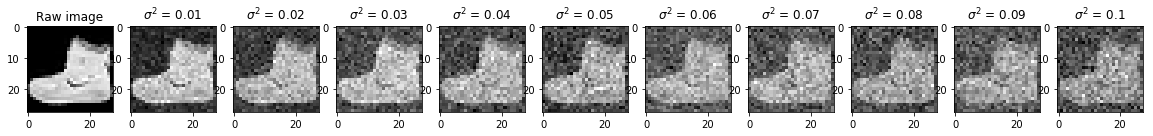

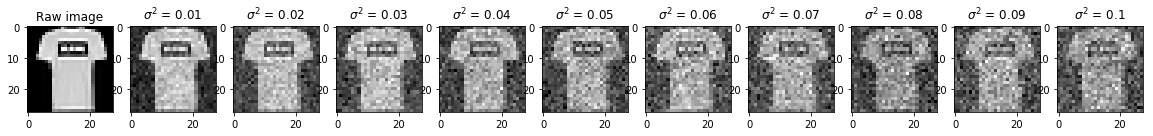

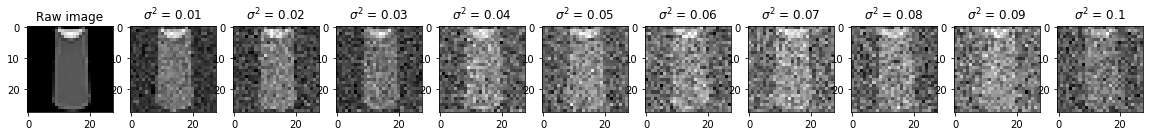

In [23]:
fig = plt.figure(figsize=(20,2))
ax = fig.subplots(1,11)
ax[0].imshow(np.reshape(X_train[0],(28,28)),cmap='gray')
ax[0].set_title("Raw image")
#ax[1].imshow(np.reshape(X_cat_noise[0],(28,28)),cmap='gray')
#ax[1].set_title("Category noise")
for i in range(len(sigma_values)):
    ax[i+1].imshow(np.reshape(X_gaus_noise[i,0,:],(28,28)),cmap='gray')
    ax[i+1].set_title(r"$\sigma^2$ = "+str(sigma_values[i]))
fig.show()

fig = plt.figure(figsize=(20,2))
ax = fig.subplots(1,11)
ax[0].imshow(np.reshape(X_train[1],(28,28)),cmap='gray')
ax[0].set_title("Raw image")
#ax[1].imshow(np.reshape(X_cat_noise[1],(28,28)),cmap='gray')
#ax[1].set_title("Category noise")
for i in range(len(sigma_values)):
    ax[i+1].imshow(np.reshape(X_gaus_noise[i,1,:],(28,28)),cmap='gray')
    ax[i+1].set_title(r"$\sigma^2$ = "+str(sigma_values[i]))
fig.show()

fig = plt.figure(figsize=(20,2))
ax = fig.subplots(1,11)
ax[0].imshow(np.reshape(X_train[2],(28,28)),cmap='gray')
ax[0].set_title("Raw image")
#ax[1].imshow(np.reshape(X_cat_noise[2],(28,28)),cmap='gray')
#ax[1].set_title("Category noise")
for i in range(len(sigma_values)):
    ax[i+1].imshow(np.reshape(X_gaus_noise[i,2,:],(28,28)),cmap='gray')
    ax[i+1].set_title(r"$\sigma^2$ = "+str(sigma_values[i]))
fig.show()

### Out of sample datapoints

One benefit of using NCP is that models trained with NCP produce high uncertainty estimates for out of distribution (OOD), or unseen, datapoints. This prevents over confident predictions on OOD data. In this section we compare the uncertainty of predictions on OOD samples made by BBB and BBB+NCP trained networks. To simulate OOD samples, we remove each of the ten categories one at a time from the training set. We train the network on each of these "leave-one-out" training datasets, and then evaluate the uncertainty of the predictions on the full test set using KL divergence and accuracy. We compare BBB alone to BBB+NCP with $\sigma^2 = \{0.01, 0.05, 1\}$. 

In [5]:
def KL_divergence(q):
    pk = np.full(10, 0.1)
    qk = np.histogram(q, density=True, bins = range(11))[0]
    idx = np.where(qk > 0)
    entropy = sp.stats.entropy(pk[idx], qk[idx])
    return entropy

confusion_matrix = lambda y: np.histogram(y,bins = range(11))[0]

In [158]:
def leave_one_out_training(X, y, c):
    X_ood = X[y != c]
    y_ood = y[y != c]
    
    minibatch_x_ood = pm.Minibatch(X_ood, batch_size=50)
    minibatch_y_ood = pm.Minibatch(y_ood, batch_size=50)
    neural_network_minibatch_ood = make_1layer_bbb_network(minibatch_x_ood, minibatch_y_ood, 784, 10, X_ood.shape[0])

    with neural_network_minibatch_ood:
        inference = pm.ADVI()
        approx_ood = pm.fit(20000, method=inference)
    
    trace_ood = approx_ood.sample(draws=2000)
    
    return trace_ood

def test_network(X, y, trace):
    test_x = theano.shared(X)
    test_y = theano.shared(y)
    neural_network_test = make_1layer_bbb_network(test_x, test_y, 784, 10, X.shape[0])
    with neural_network_test:
        ppc_ood = pm.sample_ppc(trace, samples=100)
    return ppc_ood['out']

def plot_test_results(ax, ppc, y_test, title):
    labelnames = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
    std = ppc.std(axis=0)
    std_data = [std[y_test == 0], std[y_test == 1], std[y_test == 2], std[y_test == 3],std[y_test == 4], std[y_test == 5], std[y_test == 6], std[y_test == 7], std[y_test == 8], std[y_test == 9]]
    y_pred_test = mode(ppc, axis=0).mode[0,:]
    
    ax[0].boxplot(std_data)
    ax[0].set_title("Posterior predictive standard deviation")
    ax[0].set_xticklabels(labelnames,rotation=45)
    ax[0].set_ylabel("Standard deviation")
    kl_div = np.array(list(map(lambda i: KL_divergence(y_pred_test[y_test==i]), range(10))))

    ax[1].bar(range(10), kl_div)
    ax[1].set_xticks(range(10))
    ax[1].set_xticklabels(labelnames,rotation=45)
    ax[1].set_ylabel("KL divergence")
    ax[1].set_title("Posterior predictive KL divergence")

    
    conf_mat = np.array(list(map(lambda i: confusion_matrix(y_pred_test[y_test==i]), range(10))))
    im = ax[2].imshow(conf_mat, cmap="gray")
    fig.colorbar(im, ax=ax[2])
    ax[2].set_xticks(np.arange(0, 10, 1))
    ax[2].set_yticks(np.arange(0, 10, 1))
    ax[2].set_xticklabels(labelnames,rotation=45)
    ax[2].set_yticklabels(labelnames,rotation=0)
    ax[2].set_xlabel("Prediction")
    ax[2].set_ylabel("Truth")
    plt.subplots_adjust(top=0.8)
    plt.suptitle(title, fontsize = 20)
    return ax

def plot_KL_divergence_across_datasets(ax, ppc_raw, ppc_g01, ppc_g05, ppc_g1, y_test):
    labelnames = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
    kl_div_raw = np.zeros(10)
    kl_div_g01 = np.zeros(10)
    kl_div_g05 = np.zeros(10)
    kl_div_g1 = np.zeros(10)
    
    for j in range(10):
        y_pred_test_raw = mode(ppc_raw[j,:,:], axis=0).mode[0,:]
        y_pred_test_g01 = mode(ppc_g01[j,:,:], axis=0).mode[0,:]
        y_pred_test_g05 = mode(ppc_g05[j,:,:], axis=0).mode[0,:]
        y_pred_test_g1 = mode(ppc_g1[j,:,:], axis=0).mode[0,:]
        
        kl_div_raw[j] = KL_divergence(y_pred_test_raw[y_test==j])
        kl_div_g01[j] = KL_divergence(y_pred_test_g01[y_test==j])
        kl_div_g05[j] = KL_divergence(y_pred_test_g05[y_test==j])
        kl_div_g1[j] = KL_divergence(y_pred_test_g1[y_test==j])
    
    ax.bar(np.arange(10)-0.3, kl_div_raw, width=0.2, color='orange',align='center', label = "BBB")
    ax.bar(np.arange(10)-0.1, kl_div_g01, width=0.2, color='cyan',align='center', label = r"BBB+NCP, $\sigma^2 = 0.01$")
    ax.bar(np.arange(10)+0.1, kl_div_g05, width=0.2, color='blue',align='center', label = r"BBB+NCP, $\sigma^2 = 0.05$")
    ax.bar(np.arange(10)+0.3, kl_div_g1, width=0.2, color='purple',align='center', label = r"BBB+NCP, $\sigma^2 = 0.1$")
    ax.set_xticks(np.arange(0, 10, 1))
    ax.set_xticklabels(labelnames,rotation=45)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax.set_ylabel("KL Divergence")
    
    return ax

def make_accuracy_histogram(ax, ppc_raw, y_test):
    labelnames = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
    colorvec = sns.color_palette("hls", 10)
    
    conf_mat = np.zeros((10,10))
    
    for j in range(10):
        y_pred_test = mode(ppc_raw[j,:,:], axis=0).mode[0,:]
        conf_mat[j] = confusion_matrix(y_pred_test[y_test==j])
    
    ax.bar(np.arange(10), conf_mat[:,0], width = 0.5, color = "red", label = labelnames[0])
    bottom = conf_mat[:,0]
    for j in range(1,10):
        ax.bar(np.arange(10), conf_mat[:,j], width = 0.5, bottom = bottom, color = colorvec[j], label = labelnames[j])
        bottom = bottom + conf_mat[:,j]
    ax.set_xticks(np.arange(0, 10, 1))
    ax.set_xticklabels(labelnames,rotation=45)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    return ax

def make_accuracy_histogram_2(ax, ppc_raw, ppc_g01, ppc_g05, ppc_g1, y_test, c, legend):
    labelnames = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
    colorvec = sns.color_palette("hls", 10)
    
    conf_mat = np.zeros((4,10))
    
    y_pred_test_raw = mode(ppc_raw[c,:,:], axis=0).mode[0,:]
    y_pred_test_g01 = mode(ppc_g01[c,:,:], axis=0).mode[0,:]
    y_pred_test_g05 = mode(ppc_g05[c,:,:], axis=0).mode[0,:]
    y_pred_test_g1 = mode(ppc_g1[c,:,:], axis=0).mode[0,:]
    
    conf_mat[0] = confusion_matrix(y_pred_test_raw[y_test==c])
    conf_mat[1] = confusion_matrix(y_pred_test_g01[y_test==c])
    conf_mat[2] = confusion_matrix(y_pred_test_g05[y_test==c])
    conf_mat[3] = confusion_matrix(y_pred_test_g1[y_test==c])
    
    
    ax.bar(np.arange(4), conf_mat[:,0], width = 0.5, color = "red", label = labelnames[0])
    bottom = conf_mat[:,0]
    for j in range(1,10):
        ax.bar(np.arange(4), conf_mat[:,j], width = 0.5, bottom = bottom, color = colorvec[j], label = labelnames[j])
        bottom = bottom + conf_mat[:,j]
    ax.set_xticks(np.arange(0, 4, 1))
    ax.set_xticklabels(["BBB",r"BBB+NCP, $\sigma^2$ = 0.01",r"BBB+NCP, $\sigma^2$ = 0.05",r"BBB+NCP, $\sigma^2$ = 0.1"],rotation=45)
    

    # Put a legend to the right of the current axis
    if legend:
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_title("OOD = " + labelnames[c])
    ax.set_ylim(0,1000)
    return ax

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

def make_standard_deviation_plots(ax, ppc_raw, ppc_g01, ppc_g05, ppc_g1, y_test):
    labelnames = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
    
    std_raw = ppc_raw.std(axis=1)
    std_g01 = ppc_g01.std(axis=1)
    std_g05 = ppc_g05.std(axis=1)
    std_g1 = ppc_g1.std(axis=1)
    
    std_raw_data = [std_raw[0, y_test == 0], std_raw[1, y_test == 1], std_raw[2, y_test == 2], std_raw[3, y_test == 3],std_raw[4, y_test == 4], std_raw[5, y_test == 5], std_raw[6, y_test == 6], std_raw[7, y_test == 7], std_raw[8, y_test == 8], std_raw[9, y_test == 9]]
    std_g01_data = [std_g01[0, y_test == 0], std_g01[1, y_test == 1], std_g01[2,y_test == 2], std_g01[3,y_test == 3],std_g01[4,y_test == 4], std_g01[5,y_test == 5], std_g01[6,y_test == 6], std_g01[7,y_test == 7], std_g01[8,y_test == 8], std_g01[9,y_test == 9]]
    std_g05_data = [std_g05[0, y_test == 0], std_g05[1,y_test == 1], std_g05[2,y_test == 2], std_g05[3,y_test == 3],std_g05[4,y_test == 4], std_g05[5,y_test == 5], std_g05[6,y_test == 6], std_g05[7,y_test == 7], std_g05[8,y_test == 8], std_g05[9,y_test == 9]]
    std_g1_data = [std_g1[0, y_test == 0], std_g1[1,y_test == 1], std_g1[2,y_test == 2], std_g1[3,y_test == 3],std_g1[4,y_test == 4], std_g1[5,y_test == 5], std_g1[6,y_test == 6], std_g1[7,y_test == 7], std_g1[8,y_test == 8], std_g1[9,y_test == 9]]
    
    bow_raw = ax.boxplot(std_raw_data, positions=np.arange(10)-0.3, widths=0.2)
    bow_g01 = ax.boxplot(std_g01_data, positions=np.arange(10)-0.1, widths=0.2)
    bow_g05 = ax.boxplot(std_g05_data, positions=np.arange(10)+0.1, widths=0.2)
    bow_g1 = ax.boxplot(std_g1_data, positions=np.arange(10)+0.3, widths=0.2)
    
    set_box_color(bow_raw, 'orange')
    set_box_color(bow_g01, 'cyan')
    set_box_color(bow_g05, 'blue')
    set_box_color(bow_g1, 'purple')
    
    plt.plot([], c='orange', label='BBB')
    plt.plot([], c='cyan', label=r'BBB+NCP, $\sigma^2 = 0.01$')
    plt.plot([], c='blue', label=r'BBB+NCP, $\sigma^2 = 0.05$')
    plt.plot([], c='purple', label=r'BBB+NCP, $\sigma^2 = 0.1$')
    
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    ax.set_xticks(np.arange(10))
    ax.set_title("Posterior predictive standard deviation")
    ax.set_xticklabels(labelnames,rotation=45)
    ax.set_ylabel("Standard deviation")
    ax.set_xlim(-0.5, 9.5)
    return(ax)

def make_entropy_plots(ax, ppc_raw, ppc_g01, ppc_g05, ppc_g1, y_test):
    labelnames = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
    
    std_raw = np.array(list(map(lambda j: np.array(list(map(lambda i: sp.stats.entropy(ppc_raw[j,:,i]),range(ppc_raw.shape[2])))), range(ppc_raw.shape[0]))))
    std_g01 = np.array(list(map(lambda j: np.array(list(map(lambda i: sp.stats.entropy(ppc_g01[j,:,i]),range(ppc_g01.shape[2])))), range(ppc_g01.shape[0]))))
    std_g05 = np.array(list(map(lambda j: np.array(list(map(lambda i: sp.stats.entropy(ppc_g05[j,:,i]),range(ppc_g05.shape[2])))), range(ppc_g05.shape[0]))))
    std_g1 = np.array(list(map(lambda j: np.array(list(map(lambda i: sp.stats.entropy(ppc_g1[j,:,i]),range(ppc_g1.shape[2])))), range(ppc_g1.shape[0]))))

    
    std_raw_data = [std_raw[0, y_test == 0], std_raw[1, y_test == 1], std_raw[2, y_test == 2], std_raw[3, y_test == 3],std_raw[4, y_test == 4], std_raw[5, y_test == 5], std_raw[6, y_test == 6], std_raw[7, y_test == 7], std_raw[8, y_test == 8], std_raw[9, y_test == 9]]
    std_g01_data = [std_g01[0, y_test == 0], std_g01[1, y_test == 1], std_g01[2,y_test == 2], std_g01[3,y_test == 3],std_g01[4,y_test == 4], std_g01[5,y_test == 5], std_g01[6,y_test == 6], std_g01[7,y_test == 7], std_g01[8,y_test == 8], std_g01[9,y_test == 9]]
    std_g05_data = [std_g05[0, y_test == 0], std_g05[1,y_test == 1], std_g05[2,y_test == 2], std_g05[3,y_test == 3],std_g05[4,y_test == 4], std_g05[5,y_test == 5], std_g05[6,y_test == 6], std_g05[7,y_test == 7], std_g05[8,y_test == 8], std_g05[9,y_test == 9]]
    std_g1_data = [std_g1[0, y_test == 0], std_g1[1,y_test == 1], std_g1[2,y_test == 2], std_g1[3,y_test == 3],std_g1[4,y_test == 4], std_g1[5,y_test == 5], std_g1[6,y_test == 6], std_g1[7,y_test == 7], std_g1[8,y_test == 8], std_g1[9,y_test == 9]]
    
    bow_raw = ax.boxplot(std_raw_data, positions=np.arange(10)-0.3, widths=0.2)
    bow_g01 = ax.boxplot(std_g01_data, positions=np.arange(10)-0.1, widths=0.2)
    bow_g05 = ax.boxplot(std_g05_data, positions=np.arange(10)+0.1, widths=0.2)
    bow_g1 = ax.boxplot(std_g1_data, positions=np.arange(10)+0.3, widths=0.2)
    
    set_box_color(bow_raw, 'orange')
    set_box_color(bow_g01, 'cyan')
    set_box_color(bow_g05, 'blue')
    set_box_color(bow_g1, 'purple')
    
    plt.plot([], c='orange', label='BBB')
    plt.plot([], c='cyan', label=r'BBB+NCP, $\sigma^2 = 0.01$')
    plt.plot([], c='blue', label=r'BBB+NCP, $\sigma^2 = 0.05$')
    plt.plot([], c='purple', label=r'BBB+NCP, $\sigma^2 = 0.1$')
    
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    ax.set_xticks(np.arange(10))
    ax.set_title("Posterior predictive entropy")
    ax.set_xticklabels(labelnames,rotation=45)
    ax.set_ylabel("Entropy")
    ax.set_xlim(-0.5, 9.5)
    return(ax)

def plot_entropy_across_datasets(ax, ppc_raw, ppc_g01, ppc_g05, ppc_g1, y_test):
    labelnames = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
    kl_div_raw = np.zeros(10)
    kl_div_g01 = np.zeros(10)
    kl_div_g05 = np.zeros(10)
    kl_div_g1 = np.zeros(10)
    
    for j in range(10):
        y_pred_test_raw = mode(ppc_raw[j,:,:], axis=0).mode[0,:]
        y_pred_test_g01 = mode(ppc_g01[j,:,:], axis=0).mode[0,:]
        y_pred_test_g05 = mode(ppc_g05[j,:,:], axis=0).mode[0,:]
        y_pred_test_g1 = mode(ppc_g1[j,:,:], axis=0).mode[0,:]
        
        kl_div_raw[j] = sp.stats.entropy(y_pred_test_raw[y_test==j])
        kl_div_g01[j] = sp.stats.entropy(y_pred_test_g01[y_test==j])
        kl_div_g05[j] = sp.stats.entropy(y_pred_test_g05[y_test==j])
        kl_div_g1[j] = sp.stats.entropy(y_pred_test_g1[y_test==j])
    
    ax.bar(np.arange(10)-0.3, kl_div_raw, width=0.2, color='orange',align='center', label = "BBB")
    ax.bar(np.arange(10)-0.1, kl_div_g01, width=0.2, color='cyan',align='center', label = r"BBB+NCP, $\sigma^2 = 0.01$")
    ax.bar(np.arange(10)+0.1, kl_div_g05, width=0.2, color='blue',align='center', label = r"BBB+NCP, $\sigma^2 = 0.05$")
    ax.bar(np.arange(10)+0.3, kl_div_g1, width=0.2, color='purple',align='center', label = r"BBB+NCP, $\sigma^2 = 0.1$")
    ax.set_xticks(np.arange(0, 10, 1))
    ax.set_xticklabels(labelnames,rotation=45)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax.set_ylabel("Entropy")
    
    return ax

In [75]:
## read in ppc files
with open('ppc_rawdata.pickle', 'rb') as f:
    ppc_rawdata = pickle.load(f)

with open('ppc_gaus_01.pickle', 'rb') as f:
    ppc_gaus_01 = pickle.load(f)

with open('ppc_gaus_05.pickle', 'rb') as f:
    ppc_gaus_05 = pickle.load(f)

with open('ppc_gaus_1.pickle', 'rb') as f:
    ppc_gaus_1 = pickle.load(f)

KL divergence is one metric for assesing model prediction uncertainty. The posterior predictive distribution is compared to a uniform distribution, so a small KL divergence suggests the posterior is closer to a uniform distribution, or more uncertain, whereas a large KL divergence suggests the posterior is further away from a uniform, or more certain about class assignment. The histogram below shows the KL divergences of the posterior predictive distributions of the classes when they left out during training. For example, the T-shirt/top bars represent the KL divergence of the T-shirt/top posterior predictive distribution when T-shirt/top samples are left out during training. We see that the KL divergence decreases as $\sigma^2$ increases for Coat, Sandal, and Bag, suggesting that the uncertainty of making predictions on these classes when they are OOD increases as the noise in the noisy prior increases, which is what we expect. While there is no clean discernible pattern for the other class posterior distributions, the KL divergence is always higher for BBB than BBB+NCP when $\sigma^2 = 0.1$. This means that the neural network is generally more confident on OOD samples when is is not trained with a noisy prior.

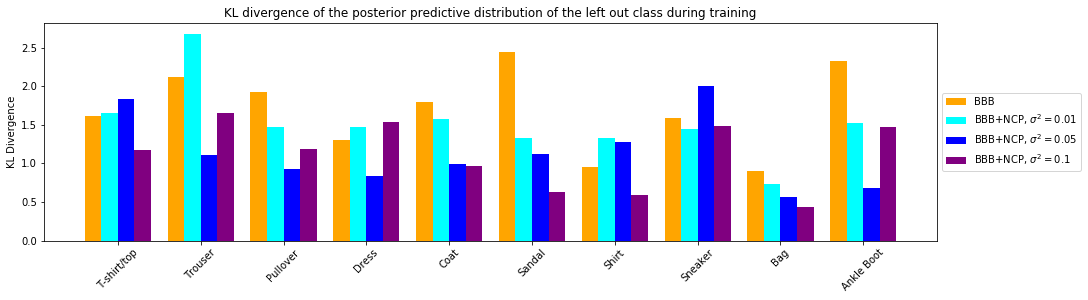

In [152]:
fig, ax = plt.subplots(figsize=(20,4))
plot_KL_divergence_across_datasets(ax, ppc_rawdata, ppc_gaus_01, ppc_gaus_05, ppc_gaus_1,y_test)
ax.set_title("KL divergence of the posterior predictive distribution of the left out class during training")
plt.show()

We also used standard deviation of the posterior predictive distribution to assess uncertainty. The boxplots below show the standard deviations of of the posterior predictive distributions of the classes when they are left out during training. For example, the T-shirt/top boxplots represent the standard deviation of the T-shirt/top posterior distribution when the T-shirt/top samples are left out during training. We see that the standard deviation of the posterior distributions increase as the noise in the NCP increases for all classes. This suggests that the network is more uncertain about the class assignments of OOD samples when the model is trained on noisier input data, which is what we expect. 

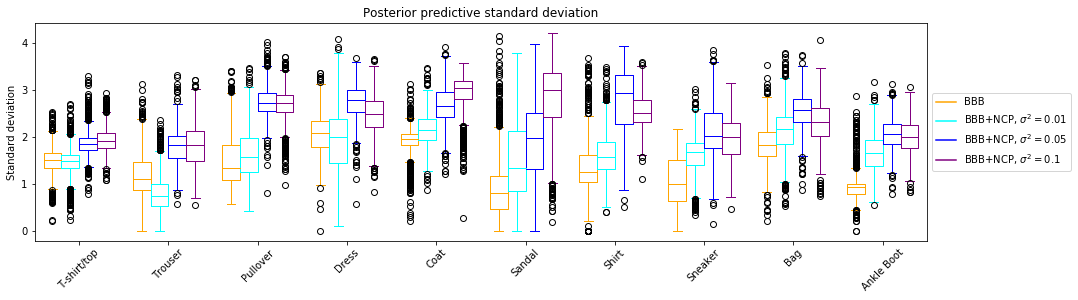

In [149]:
fig, ax = plt.subplots(figsize=(20,4))
make_standard_deviation_plots(ax, ppc_rawdata, ppc_gaus_01, ppc_gaus_05, ppc_gaus_1, y_test)
plt.show()

The plots below show the posterior predictive distribution for each setting. Each individual plots represents the posterior distribution of a particular class when that class is left out of the training sample. Each bar in the plot represents either BBB or BBB+NCP with a particular value of $\sigma^2$. In general, we see that when the model is trained using BBB only, the class assignments are split between fewer classes, and when the model is trained with BBB+NCP, the class assignments are split between more classes. This suggests that using NCP increases the uncertainty of OOD samples.  

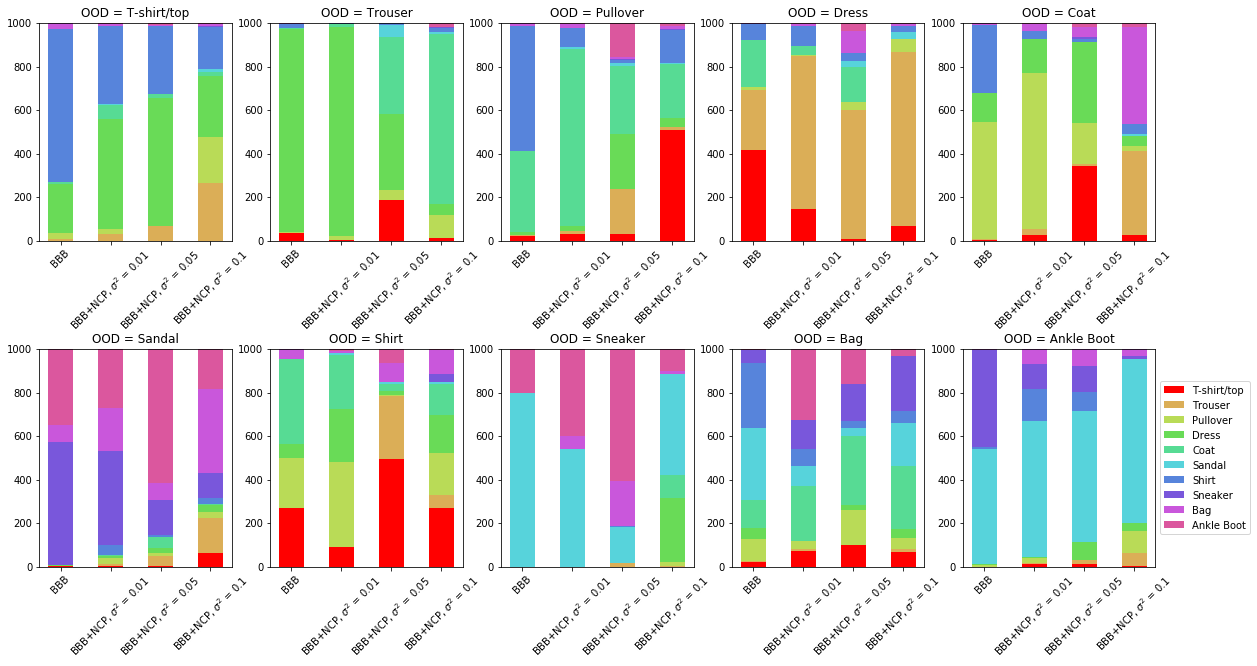

In [122]:
fig,ax = plt.subplots(2,5, figsize=(20,10))
make_accuracy_histogram_2(ax[0,0], ppc_rawdata, ppc_gaus_01, ppc_gaus_05, ppc_gaus_1, y_test, 0, False)
make_accuracy_histogram_2(ax[0,1], ppc_rawdata, ppc_gaus_01, ppc_gaus_05, ppc_gaus_1, y_test, 1, False)
make_accuracy_histogram_2(ax[0,2], ppc_rawdata, ppc_gaus_01, ppc_gaus_05, ppc_gaus_1, y_test, 2, False)
make_accuracy_histogram_2(ax[0,3], ppc_rawdata, ppc_gaus_01, ppc_gaus_05, ppc_gaus_1, y_test, 3, False)
make_accuracy_histogram_2(ax[0,4], ppc_rawdata, ppc_gaus_01, ppc_gaus_05, ppc_gaus_1, y_test, 4, False)
make_accuracy_histogram_2(ax[1,0], ppc_rawdata, ppc_gaus_01, ppc_gaus_05, ppc_gaus_1, y_test, 5, False)
make_accuracy_histogram_2(ax[1,1], ppc_rawdata, ppc_gaus_01, ppc_gaus_05, ppc_gaus_1, y_test, 6, False)
make_accuracy_histogram_2(ax[1,2], ppc_rawdata, ppc_gaus_01, ppc_gaus_05, ppc_gaus_1, y_test, 7, False)
make_accuracy_histogram_2(ax[1,3], ppc_rawdata, ppc_gaus_01, ppc_gaus_05, ppc_gaus_1, y_test, 8, False)
make_accuracy_histogram_2(ax[1,4], ppc_rawdata, ppc_gaus_01, ppc_gaus_05, ppc_gaus_1, y_test, 9, True)
plt.subplots_adjust(hspace=0.5)
plt.show()

In [13]:
ppc_rawdata = np.zeros((10,100,10000))
for i in range(10):
    trace_rawdata = leave_one_out_training(X_train, y_train, i)
    ppc_rawdata[i,:,:] = test_network(X_test, y_test, trace_rawdata)
    
with open('ppc_rawdata.pickle', 'wb') as f:
     pickle.dump(ppc_rawdata, f)


Average Loss = 208.2: 100%|██████████| 20000/20000 [07:03<00:00, 47.24it/s] 
Finished [100%]: Average Loss = 208.25
Average Loss = 223.68: 100%|██████████| 20000/20000 [07:23<00:00, 45.09it/s]
Finished [100%]: Average Loss = 223.64
Average Loss = 205.81: 100%|██████████| 20000/20000 [06:29<00:00, 51.31it/s]
Finished [100%]: Average Loss = 205.83
Average Loss = 210.03: 100%|██████████| 20000/20000 [06:24<00:00, 51.99it/s]
Finished [100%]: Average Loss = 209.87
Average Loss = 203.16: 100%|██████████| 20000/20000 [06:22<00:00, 52.24it/s]
Finished [100%]: Average Loss = 203.25
Average Loss = 219.38: 100%|██████████| 20000/20000 [06:36<00:00, 50.41it/s]
Finished [100%]: Average Loss = 219.46
Average Loss = 195.2: 100%|██████████| 20000/20000 [06:47<00:00, 49.03it/s] 
Finished [100%]: Average Loss = 195.25
Average Loss = 219.85: 100%|██████████| 20000/20000 [06:25<00:00, 51.93it/s]
Finished [100%]: Average Loss = 219.66
Average Loss = 219.23: 100%|██████████| 20000/20000 [06:35<00:00, 50.52i

In [14]:
ppc_gaus_01 = np.zeros((10,100,10000))
for i in range(10):
    trace_gaus_01 = leave_one_out_training(X_gaus_noise[0,:,:], y_train, i)
    ppc_gaus_01[i,:,:] = test_network(X_test, y_test, trace_gaus_01)
    
with open('ppc_gaus_01.pickle', 'wb') as f:
     pickle.dump(ppc_gaus_01, f)
        
ppc_gaus_05 = np.zeros((10,100,10000))
for i in range(10):
    trace_gaus_05 = leave_one_out_training(X_gaus_noise[4,:,:], y_train, i)
    ppc_gaus_05[i,:,:] = test_network(X_test, y_test, trace_gaus_05)
    
with open('ppc_gaus_05.pickle', 'wb') as f:
     pickle.dump(ppc_gaus_05, f)
        
ppc_gaus_1 = np.zeros((10,100,10000))
for i in range(10):
    trace_gaus_1 = leave_one_out_training(X_gaus_noise[9,:,:], y_train, i)
    ppc_gaus_1[i,:,:] = test_network(X_test, y_test, trace_gaus_1)
    
with open('ppc_gaus_1.pickle', 'wb') as f:
     pickle.dump(ppc_gaus_1, f)

Average Loss = 282.88: 100%|██████████| 20000/20000 [06:28<00:00, 51.42it/s]
Finished [100%]: Average Loss = 282.78
Average Loss = 281.59: 100%|██████████| 20000/20000 [06:26<00:00, 51.77it/s]
Finished [100%]: Average Loss = 281.45
Average Loss = 280.99: 100%|██████████| 20000/20000 [06:27<00:00, 51.65it/s]
Finished [100%]: Average Loss = 281.17
Average Loss = 274.88: 100%|██████████| 20000/20000 [06:26<00:00, 51.73it/s]
Finished [100%]: Average Loss = 275.04
Average Loss = 259.59: 100%|██████████| 20000/20000 [06:28<00:00, 51.53it/s]
Finished [100%]: Average Loss = 259.46
Average Loss = 292.57: 100%|██████████| 20000/20000 [06:32<00:00, 51.00it/s]
Finished [100%]: Average Loss = 292.55
Average Loss = 270.38: 100%|██████████| 20000/20000 [06:31<00:00, 51.08it/s]
Finished [100%]: Average Loss = 270.29
Average Loss = 280.76: 100%|██████████| 20000/20000 [06:29<00:00, 51.30it/s]
Finished [100%]: Average Loss = 280.64
Average Loss = 281.28: 100%|██████████| 20000/20000 [06:29<00:00, 51.31i